In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
#!pip install tensorflow_datasets

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [4]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.0', True)

In [5]:
max_sequence = 9
blank_num = -1
characters_0 = '0123456789'
characters_alphabet = 'ABCDEFGHIJKLMNPQRSTUVWXYZ-'
characters_1 = '가나다라마바사아자하거너더러머버서어저허고노도로모보소오조호구누두루무부수우주'
characters_1d = 'GNDLMBSOJHgndlmbsojhgNDLMBSOJHGNDLMBSUJ'
characters_2 = '대배해제기교표외인천국합육공영준협정울경강원충북운남전산광'
characters_2d = 'DBHJGGPYICGHUGYJHJUGKWCBUNJSG'
characters_3 = '_       abcd  '
plate_characters = characters_0 + characters_alphabet + characters_1 + characters_2 + characters_3
num_classes = len(plate_characters)
num_classes

118

In [6]:
padded_image_shape = (16*6, 16*6*3)
EOS = num_classes - 1
SOS = EOS - 1
head_n = 8
l1 = 1e-8
activation = 'relu'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
path_weight = "model/LPR"
is_align = True
max_data_m = 10#000
SOS, EOS

(116, 117)

In [7]:
path_synthetic = '/home/mvlab/Downloads/plate_generator/gen/'
path_label = path_synthetic + 'label.csv'

In [8]:
os.path.isdir(path_synthetic), os.path.isfile(path_label)

(True, True)

In [9]:
np.set_printoptions(precision=3)

In [10]:
df = pd.read_csv(path_label, sep=' ')
df.shape

(6251, 29)

In [11]:
df.columns

Index(['path', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'type', 'text',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17'],
      dtype='object')

In [12]:
df.head()

,path,x0,y0,x1,y1,x2,y2,x3,y3,type,...,8,9,10,11,12,13,14,15,16,17
0,1_49소4994.png,263,56,782,56,782,165,263,165,1,...,608,110,665,110,723,110,0.0,0.0,0.0,0.0
1,1_87거5293.png,260,55,779,55,779,164,260,164,1,...,601,109,658,109,715,109,0.0,0.0,0.0,0.0
2,1_52머9472.png,262,50,781,50,781,159,262,159,1,...,598,104,654,104,710,104,0.0,0.0,0.0,0.0
3,1_20모3579.png,260,55,779,55,779,164,260,164,1,...,600,109,657,109,714,109,0.0,0.0,0.0,0.0
4,1_79노4785.png,255,52,774,52,774,161,255,161,1,...,600,106,658,106,715,106,0.0,0.0,0.0,0.0


In [13]:
df['type'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
df.iloc[0]

path    1_49소4994.png
x0                263
y0                 56
x1                782
y1                 56
x2                782
y2                165
x3                263
y3                165
type                1
text          49소4994
0                 336
1                 110
2                 394
3                 110
4                 464
5                 104
6                 550
7                 110
8                 608
9                 110
10                665
11                110
12                723
13                110
14                  0
15                  0
16                  0
17                  0
Name: 0, dtype: object

In [15]:
def read_synthetic(max_m=10000):
    df = pd.read_csv(path_label, sep=' ')
    df = df[:max_m]
    m = len(df)
    x0 = df['x0']
    x1 = df['x1']
    x2 = df['x2']
    x3 = df['x3']
    y0 = df['y0']
    y1 = df['y1']
    y2 = df['y2']
    y3 = df['y3']
    
    min_x = np.minimum(df['x0'], df['x3'])
    min_y = np.minimum(df['y0'], df['y1'])
    max_x = np.maximum(df['x1'], df['x2'])
    max_y = np.maximum(df['y2'], df['y3'])
    box_ratio = (max_x - min_x) / (max_y - min_y)
    shear_y0 = -box_ratio * (y2 - y3) / (x2 - x3)
    shear_y1 = -box_ratio * (y1 - y0) / (x1 - x0)
    shear_x0 = -box_ratio * (x3 - x0) / (y3 - y0)
    shear_x1 = -box_ratio * (x2 - x1) / (y2 - y1)
    shear_y = (shear_y0 + shear_y1) / 2
    shear_x = (shear_x0 + shear_x1) / 2
    df['min_x'] = min_x
    df['min_y'] = min_y
    df['max_x'] = max_x
    df['max_y'] = max_y
    df['shear_x'] = shear_x
    df['shear_y'] = shear_y

    plate_chars = plate_characters
    bbox = df[['min_x', 'min_y', 'max_x', 'max_y', 'type']].values
    vertex = df[['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3','type']].values
    cxy_col = [str(i) for i in range(18)]
    char_cxy = df[cxy_col].values
    plate_type = df['type'].values

    text_len = max_sequence
    m = len(df)
    class_nums = np.zeros((m, text_len)) - 1
    for i in range(m):
        text0 = df.loc[i, 'text']
        for j in range(len(text0)):
            class_num = plate_chars.index(text0[j])
            class_nums[i, j] = class_num
    print('class_nums', class_nums.shape)
    print('char_cxy', char_cxy.shape)
    
    label = np.concatenate((vertex, class_nums, char_cxy), axis=-1)    
    print('label', label.shape)
    
    img_path_list = list(path_synthetic + df['path'].values)
    return img_path_list, label

In [16]:
paths, labels = read_synthetic(10000)
print('labels', len(labels), len(paths))
print(labels[0])

class_nums (6251, 9)
char_cxy (6251, 18)
label (6251, 36)
labels 6251 6251
[263.  56. 782.  56. 782. 165. 263. 165.   1.   4.   9.  62.   4.   9.
   9.   4.  -1.  -1. 336. 110. 394. 110. 464. 104. 550. 110. 608. 110.
 665. 110. 723. 110.   0.   0.   0.   0.]


In [17]:
i_index = np.arange(10)
np.random.shuffle(i_index)
i_index

array([7, 0, 6, 2, 4, 8, 5, 1, 9, 3])

In [18]:
x_list = []
y_list = []
i_index = np.arange(len(paths))
np.random.shuffle(i_index)
for i in i_index:
    path_img = paths[i]
    label = labels[i]
    if os.path.isfile(path_img):
        img = Image.open(path_img)
        arr = np.array(img)
        
        
        img_h, img_w, img_c = arr.shape
        #print('label', label.shape)
        coord = label[:8]
        type_text = label[8:8+1+max_sequence]        
        char_cxy = label[8+1+max_sequence:]
        
        coord_2d = np.reshape(coord, [-1, 2])
        coord_2d_norm = coord_2d / (np.array((img_w, img_h), np.float))
        coord_norm = np.reshape(coord_2d_norm, [-1])
        
        char_cxy_2d = np.reshape(char_cxy, [-1, 2])
        char_cxy_2d_norm = char_cxy_2d / (np.array((img_w, img_h), np.float))
        char_cxy_norm = np.reshape(char_cxy_2d_norm, [-1])
        
        label_norm = np.concatenate((coord_norm, type_text, char_cxy_norm), -1)
        
        x_list.append(arr)
        y_list.append(label_norm)
        if len(x_list)%100 == 0 :
            print(len(paths), len(x_list))
        if len(x_list)>max_data_m:
            break
        
print('x_list', len(x_list), len(y_list))

x_list 11 11


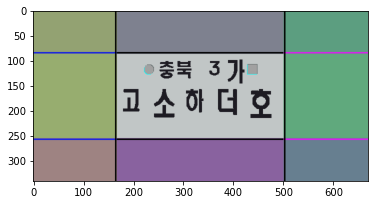

In [19]:
plt.imshow(x_list[0])

In [20]:
def visualize_plate(
    image, y, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""    
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    vertices_norm = y[:8]    
    plate_type = y[8]
    plate_text = y[9:]
    vertices_norm_2d = np.reshape(vertices_norm, [-1, 2])
    vertices_2d = vertices_norm_2d * np.array((img_w, img_h), np.float)
    
    x0, y0, x1, y1, x2, y2, x3, y3 = np.reshape(vertices_2d, [-1])
    
    w, h = x2 - x1, y2 - y1    
    color = [1,0,0]
    linewidth = 10
    plt.plot(x0, y0, x1, y1, 'go-', linewidth=linewidth)
    plt.plot(x1, y1, x2, y2, 'ro--', linewidth=linewidth)
    plt.plot(x2, y2, x3, y3, marker = 'o', linewidth=linewidth)
    plt.plot(x3, y3, x0, y0, marker = 'o', linewidth=linewidth)
        
    txt = str.format('(%d)' % (plate_type)) + str(plate_text)
    ax.text(x0, y0, txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

In [21]:
def display_data(X, Y, stride=1):
    for i in range(len(X)):
        if i%stride==0:            
            ax = visualize_plate(X[i], Y[i])

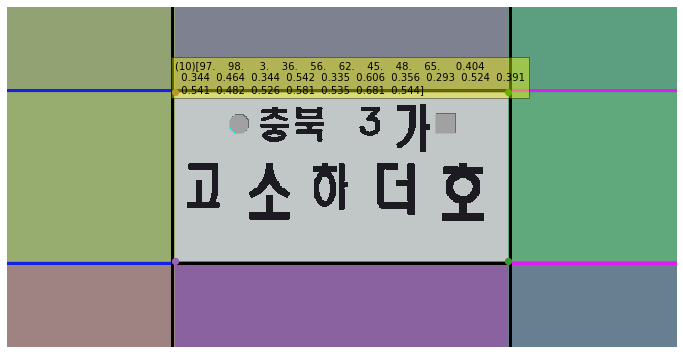

In [22]:
display_data(x_list, y_list, stride=1000)

In [23]:
def convert_norm_to_uv(coord):
    return coord * 2 - 1 

def convert_uv_to_norm_to(coord):
    return coord + 1 / 2


def transform_uv(uv, mat):
    #coord : (m, n, 2)
    #theta : (m, 2, 3)    
    inv_mat = tf.linalg.inv(mat)        
    xyo = tf.concat((uv, 1 + 0 * uv[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', inv_mat, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])
    new_xy = new_xy[:, :, :2]
    return new_xy


def transform_xy(xy, theta):
    m = tf.shape(xy)[0]
    theta = tf.linalg.inv(theta)
    theta = theta[:, :2]
    # xy [0, 1] > [-1, 1]
    xy = (xy - 0.5) * 2
    theta = tf.reshape(theta, [-1, 2, 3])
    xy = tf.reshape(xy, [m, -1, 2])
    xyo = tf.concat((xy, 1 + 0 * xy[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', theta, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])

    return new_xy

In [24]:
def shift_matrix(x, y):
    z = x * 0
    o = z + 1
    mat = tf.stack([o, z, x, z, o, y], -1)
    row = tf.stack([z, z, z+1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def scale_matrix(x, y):
    z = x * 0
    mat = tf.stack([x, z, z, z, y, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def rotate_matrix(radian):
    c = tf.cos(radian)
    s = tf.sin(radian)
    z = c * 0
    mat = tf.stack([c, -s, z, s, c, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


def shear_x_matrix(radian_x):
    x = tan(radian_x)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, z, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_y_matrix(radian_y):
    y = tan(radian_y)
    z = y * 0
    o = z + 1
    mat = tf.stack([o, z, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_matrix(radian_x, radian_y):
    
    x = tan(radian_x)
    y = tan(radian_y)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


In [25]:
#y = sign(x) = -1 if x < 0; 0 if x == 0; 1 if x > 0.
def sign(v):
    return tf.cast(v > 0, tf.float32) + -1 * tf.cast(v < 0, tf.float32)

def tan(v):
    return tf.sin(v)/tf.cos(v)

In [26]:
def get_x1(t1, t2, width, height):
    a = sign(t2) * width - height * tf.sin(t2)/tf.cos(t2)
    b = (sign(t2) * tf.cos(t1) * tf.cos(t2) - sign(t1) * tf.sin(t1) * tf.sin(t2)) / (tf.cos(t1)*tf.cos(t2))
    x1 = a / b
    return x1

def get_v1_v2(t1, t2, width, height):
    x1 = get_x1(t1, t2, width, height)
    #x1 = get_x1_new(t1, t2, width, height)
    y1 = x1 / tf.cos(t1) * tf.sin(t1)
    x2 = width * sign(t2) - sign(t2) * x1
    y2 = height - sign(t1) * y1
    return x1,y1,x2,y2

def get_wH(t1, t2, width, height):
    x1, y1, x2, y2 = get_v1_v2(t1, t2, width, height)
    w = x1/tf.cos(t1)
    h = y2/tf.cos(t2)
    pi = 3.141592653589793
    right = 90 * pi / 180
    H = tf.sin(right - t1 - t2) * h
    return w / width, H / height

def get_align_scale_matrix(radian_x, radian_y, width, height):
    min_angle = 0.0001
    rotate_mat = rotate_matrix(-radian_y)
    shear_x_mat = shear_x_matrix(-radian_x - radian_y)
    
    is_zero_radian_x = tf.cast(tf.abs(radian_x) < min_angle, tf.float32)
    is_zero_radian_y = tf.cast(tf.abs(radian_y) < min_angle, tf.float32)
    radian_x = is_zero_radian_x * sign(radian_x) * radian_x * 0+min_angle + (1-is_zero_radian_x) * radian_x
    radian_y = is_zero_radian_y * sign(radian_y) * radian_y * 0+min_angle + (1-is_zero_radian_y) * radian_y
    radian_x = tf.where(tf.abs(radian_x) < min_angle, sign(radian_x) * radian_x * 0+min_angle, radian_x)
    radian_y = tf.where(tf.abs(radian_y) < min_angle, sign(radian_y) * radian_y * 0+min_angle, radian_y)
    w, h = get_wH(-radian_y, -radian_x, width, height) 
    scale_down_rotate_o = scale_matrix(w, h)

    rot_mat = tf.matmul(rotate_mat, shear_x_mat)
    rot_scale_mat = tf.matmul(rot_mat, scale_down_rotate_o) #[2,3,3] vs [4,3,3]

    return rot_scale_mat

In [125]:
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]
    
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])  # (3, h*w)
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    # sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))#(num_batch, 3, h*w)
    sampling_grid = tf.tile(sampling_grid, [num_batch, 1, 1])  # (num_batch, 3, h*w)
    theta = tf.cast(theta, tf.float32)
    sampling_grid = tf.cast(sampling_grid, tf.float32)

    batch_grids = tf.matmul(theta, sampling_grid)  # (m, 2, 3)@(m, 3, h*w)=(m,2,h*w)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])
    return batch_grids


def get_pixel_value(img, x, y):
    # img (m,h,w,c)
    # x,y (m,h,w)
    shape = tf.shape(x)
    m = shape[0]
    h = shape[1]
    w = shape[2]
    batch_idx = tf.range(0, m)
    batch_idx = tf.reshape(batch_idx, [m, 1, 1])
    b = tf.tile(batch_idx, [1, h, w])

    indices = tf.stack([b, y, x], axis=3)  # (m,h,w,3)

    return tf.gather_nd(img, indices)


def bilinear_sampler(img, batch_grids):
    # batch_grids (m, 2, h, w)
    # img (m,h,w,c)
    uv_x = batch_grids[:, 0]
    uv_y = batch_grids[:, 1]
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, tf.float32)
    max_x = tf.cast(W - 1, tf.float32)
    # x [-1, 1]
    x = 0.5 * ((uv_x + 1.0) * max_x)
    y = 0.5 * ((uv_y + 1.0) * max_y)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.floor(x)  # precision bad?
    x1 = x0 + 1
    y0 = tf.floor(y)
    y1 = y0 + 1

    # clip out of boundary index
    x0 = tf.clip_by_value(x0, 0, max_x)
    x1 = tf.clip_by_value(x1, 0, max_x)
    y0 = tf.clip_by_value(y0, 0, max_y)
    y1 = tf.clip_by_value(y1, 0, max_y)

    # deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    wa = tf.expand_dims(wa, -1)
    wb = tf.expand_dims(wb, -1)
    wc = tf.expand_dims(wc, -1)
    wd = tf.expand_dims(wd, -1)

    x0 = tf.cast(x0, tf.int32)
    x1 = tf.cast(x1, tf.int32)
    y0 = tf.cast(y0, tf.int32)
    y1 = tf.cast(y1, tf.int32)

    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
    #out = wa * Ia + wb * Ib + wc * Ic + wd * Id

    return out


def sampling(net, theta, dst_h, dst_w):
    theta = tf.reshape(theta, [-1, 2, 3])
    #h = tf.shape(net)[1]
    #w = tf.shape(net)[2]
    batch_grids = affine_grid_generator(dst_h, dst_w, theta)
    out = bilinear_sampler(net, batch_grids)
    return out

In [82]:
def get_box_center_and_size(bbox):
    x0, y0, x1, y1 = tf.split(bbox, 4, -1)
    w = x1 - x0
    h = y1 - y0
    cx = (x1 + x0) / 2
    cy = (y1 + y0) / 2
    return cx, cy, w, h

In [83]:
type(x_list), len(x_list)

(list, 11)

In [84]:
X = tf.constant(np.stack(x_list[:1]))
Y = tf.constant(np.stack(y_list[:1]))
X = tf.cast(X, tf.float32)
X.shape, Y.shape, Y[0]

(TensorShape([1, 340, 670, 3]),
 TensorShape([1, 36]),
 <tf.Tensor: shape=(36,), dtype=float64, numpy=
 array([ 0.25,  0.25,  0.75,  0.25,  0.75,  0.75,  0.25,  0.75, 10.  ,
        97.  , 98.  ,  3.  , 36.  , 56.  , 62.  , 45.  , 48.  , 65.  ,
         0.4 ,  0.34,  0.46,  0.34,  0.54,  0.34,  0.61,  0.36,  0.29,
         0.52,  0.39,  0.54,  0.48,  0.53,  0.58,  0.54,  0.68,  0.54])>)

In [85]:
def get_theta_from_coords(coords):
    x0 = coords[:, 0, 0]
    y0 = coords[:, 0, 1]
    x1 = coords[:, 1, 0]
    y1 = coords[:, 1, 1]
    x2 = coords[:, 2, 0]
    y2 = coords[:, 2, 1]
    x3 = coords[:, 3, 0]
    y3 = coords[:, 3, 1]
        
    tx = (x0 + x1 + x2 + x3)/4
    ty = (y0 + y1 + y2 + y3)/4
    #scale_x = ((x1 - x0) + (x2 - x3))/2    
    #scale_y = ((y3 - y0) + (y2 - y1))/2
    shear_x = -((x0 - x3) / (y0 - y3) + (x1 - x2) / (y1 - y2)) / 2
    shear_y = -((y1 - y0) / (x1 - x0) + (y2 - y3) / (x2 - x3)) / 2
    shear_x = tf.math.atan(shear_x)
    shear_y = tf.math.atan(shear_y)
    
    x_min = tf.reduce_min(coords[:, :, 0], 1)
    x_max = tf.reduce_max(coords[:, :, 0], 1)
    y_min = tf.reduce_min(coords[:, :, 1], 1)
    y_max = tf.reduce_max(coords[:, :, 1], 1)
    w = x_max - x_min
    h = y_max - y_min
    scale_x = w/2
    scale_y = h/2
    
    return tx, ty, scale_x, scale_y, shear_x, shear_y

In [86]:
def generate_transform_matrix(tx, ty, sx, sy, shear_x, shear_y):    
    shift_mat = shift_matrix(tx, ty)
    scale_mat = scale_matrix(sx, sy)    
    
    w = sx * 2
    h = sy * 2
    align_scale_mat = get_align_scale_matrix(shear_x, shear_y, w, h)    
    tm = tf.matmul(shift_mat, align_scale_mat)
    tm = tf.matmul(tm, scale_mat)
    tm = tf.cast(tm, tf.float32)
    return tm

def convert_transform_matrix(tx, ty, sx, sy, shear_x, shear_y):    
    shift_mat = shift_matrix(tx, ty)
    scale_mat = scale_matrix(sx, sy)    
    shear_mat = shear_matrix(shear_x, shear_y)
    
    tm = tf.matmul(shift_mat, scale_mat)
    tm = tf.matmul(tm, shear_mat)
    tm = tf.cast(tm, tf.float32)
    return tm

In [87]:
def get_align_matrix(vertices_uv):
    cx, cy, sx, sy, shear_x, shear_y = get_theta_from_coords(vertices_uv)        
    transform_mat = generate_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
    return transform_mat

In [88]:
def get_augment_transform_matrix(m, delta):
    z = tf.zeros(m)    
    shear_y = tf.random.normal(tf.shape(z), stddev=delta)
    shear_x = tf.random.normal(tf.shape(z), stddev=delta)
    ty = tf.random.normal(tf.shape(z), stddev=delta)
    tx = tf.random.normal(tf.shape(z), stddev=delta)

    #width_scope = [0.07, 0.3]  # from [0.156, 0.116]
    sx = tf.random.uniform(tf.shape(z), minval=1, maxval=1 + delta)
    sy = tf.random.uniform(tf.shape(z), minval=1, maxval=1 + delta)
    sx += tf.abs(tx)
    sy += tf.abs(ty)

    #thetas = tf.stack([tx, ty, sx, sy, shear_x, shear_y], 1)
    return tx, ty, sx, sy, shear_x, shear_y

In [89]:
def get_aug_matrix(vertices_uv, delta):    
    transform_mat = get_align_matrix(vertices_uv)
    m = tf.shape(vertices_uv)[0]
    
    cx, cy, sx, sy, shear_x, shear_y = get_augment_transform_matrix(m, delta)    
    transform_mat = convert_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
    
    return transform_mat

In [90]:
Y = tf.cast(Y, tf.float32)
vertices = Y[:, :8]
plate_type = Y[:, 8]
plate_text = Y[:, 9:9 + max_sequence]
char_cxy = Y[:, 9 + max_sequence:9 + max_sequence + max_sequence*2]

vertices = tf.reshape(vertices, [-1, 4, 2])
char_cxy = tf.reshape(char_cxy, [-1, max_sequence, 2])
vertices_uv = convert_norm_to_uv(vertices)
char_cxy_uv = convert_norm_to_uv(char_cxy)
align_mat = get_align_matrix(vertices_uv)
aug_mat = get_aug_matrix(vertices_uv, delta=0.1)
transform_mat = tf.matmul(align_mat, aug_mat)
transform_mat.shape, transform_mat.dtype

(TensorShape([1, 3, 3]), tf.float32)

In [91]:
x_sampled = sampling(X, transform_mat[:, :2], 200, 400)
x_sampled.shape

TensorShape([1, 200, 400, 3])

In [92]:
transformed_vertices_uv = transform_uv(vertices_uv, transform_mat)
transformed_char_cxy_uv = transform_uv(char_cxy_uv, transform_mat)
transformed_vertices_uv.shape, transformed_char_cxy_uv.shape, transformed_vertices_uv[0], transformed_char_cxy_uv[0]

(TensorShape([1, 4, 2]),
 TensorShape([1, 9, 2]),
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[-0.9 , -1.05],
        [ 0.95, -0.88],
        [ 0.88,  1.  ],
        [-0.97,  0.83]], dtype=float32)>,
 <tf.Tensor: shape=(9, 2), dtype=float32, numpy=
 array([[-3.38e-01, -6.39e-01],
        [-1.16e-01, -6.19e-01],
        [ 1.74e-01, -6.26e-01],
        [ 4.10e-01, -5.26e-01],
        [-7.80e-01,  7.35e-04],
        [-4.16e-01,  1.01e-01],
        [-7.47e-02,  7.64e-02],
        [ 2.91e-01,  1.43e-01],
        [ 6.62e-01,  2.11e-01]], dtype=float32)>)

In [93]:
y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y = get_theta_from_coords(transformed_vertices_uv)        
tf.stack((y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y), -1)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[-0.01, -0.02,  0.96,  1.02,  0.04, -0.09]], dtype=float32)>

In [94]:
transformed_char_cxy_uv = transform_uv(char_cxy_uv, transform_mat)
transformed_char_cxy_uv.shape, transformed_char_cxy_uv[0]

(TensorShape([1, 9, 2]),
 <tf.Tensor: shape=(9, 2), dtype=float32, numpy=
 array([[-3.38e-01, -6.39e-01],
        [-1.16e-01, -6.19e-01],
        [ 1.74e-01, -6.26e-01],
        [ 4.10e-01, -5.26e-01],
        [-7.80e-01,  7.35e-04],
        [-4.16e-01,  1.01e-01],
        [-7.47e-02,  7.64e-02],
        [ 2.91e-01,  1.43e-01],
        [ 6.62e-01,  2.11e-01]], dtype=float32)>)

In [95]:
x_sampled_img = x_sampled.numpy().astype(np.uint8)
x_sampled_img.shape

(1, 200, 400, 3)

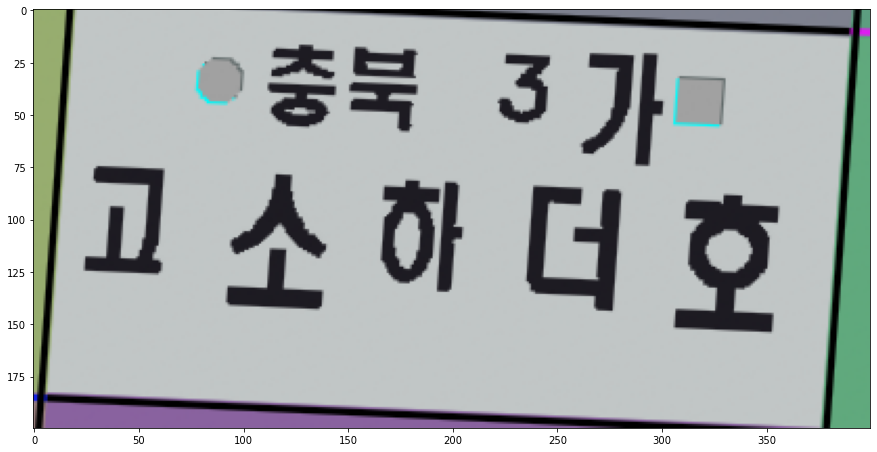

In [96]:
x_sample_concat = np.concatenate((x_sampled_img), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

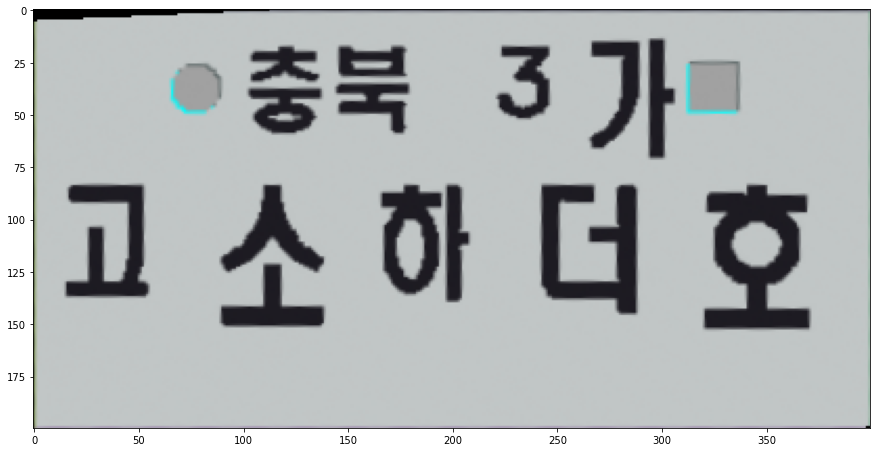

In [97]:
aug_align_mat = generate_transform_matrix(y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y)
x_aug_aligned_sampled = sampling(x_sampled, aug_align_mat[:, :2], 200, 400)
x_aug_aligned_sampled.shape
x_aug_aligned_sampled_img = x_aug_aligned_sampled.numpy().astype(np.uint8)
x_sample_concat = np.concatenate((x_aug_aligned_sampled_img[:10]), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

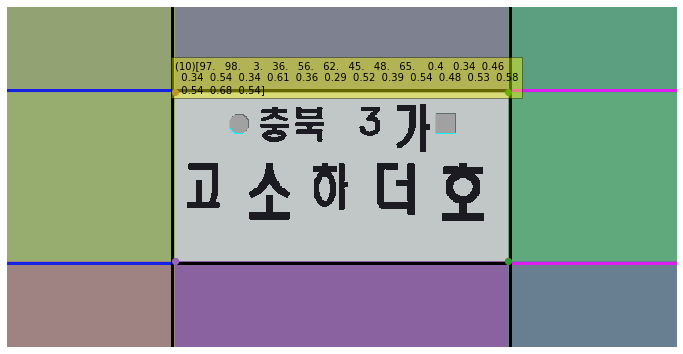

In [98]:
ax = visualize_plate(x_list[0], y_list[0])

In [99]:
def preprocess_data(X, label):
    
    label = tf.expand_dims(label, 0)
    X = tf.expand_dims(X, 0)
    vertices = label[:, :8]
    plate_type = label[:, 8]
    plate_text = label[:, 9:9 + max_sequence]
    char_cxy = label[:, 9 + max_sequence:9 + max_sequence + max_sequence*2]

    vertices = tf.reshape(vertices, [-1, 4, 2])
    char_cxy = tf.reshape(char_cxy, [-1, max_sequence, 2])
    vertices_uv = convert_norm_to_uv(vertices)
    char_cxy_uv = convert_norm_to_uv(char_cxy)
    align_mat = get_align_matrix(vertices_uv)
    aug_mat = get_aug_matrix(vertices_uv, delta=0.01)#hyper
    transform_mat = tf.matmul(align_mat, aug_mat)
    
    X = tf.cast(X, tf.float32)
    x_sampled = sampling(X, transform_mat[:, :2], padded_image_shape[0], padded_image_shape[1])
    transformed_vertices_uv = transform_uv(vertices_uv, transform_mat)
    transformed_char_cxy_uv = transform_uv(char_cxy_uv, transform_mat)
    #image = tf.image.resize(image, padded_image_shape)    
    y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y = get_theta_from_coords(transformed_vertices_uv)
    y_align = tf.stack((y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y), -1)
    
    return x_sampled, y_align, plate_text, transformed_char_cxy_uv

In [100]:
class LabelEncoder:
    
    def __init__(self):
        pass    
    
    def _encode_sample(self, image_shape, gt_text, gt_cxy_uv):
        
        gt_text = tf.reshape(gt_text, [-1])
        gt_cxy_uv_flat = tf.reshape(gt_cxy_uv, [-1])
        label = tf.concat([gt_text, gt_cxy_uv_flat], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, y_align, gt_text, gt_cxy_uv):
        
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]        
                            
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_text[i], gt_cxy_uv[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        out = {'align': y_align, 'recog': label}
        return batch_images, out#dual      
        

In [101]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [102]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, name : str) -> Tensor:
    kernel_size = 3
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer,
               name=name+'conv_0')(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer,
               name=name+'conv_1')(y)   
    
    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer,
                   name=name+'conv_down')(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out

def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    name = 'recog_'
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer, 
               name=name+'conv_0')(inputs)
    t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 2, 2]#resnet-18
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]        
        for j in range(num_blocks):
            name_block = name + str(i) + '_' +str(j) + '_'
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters, name=name_block)
        if i>=1:
            t_list.append(t)
        num_filters *= 2    
        
    return t


def create_align_net(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    name = 'align_'
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer, 
               name=name+'conv_0')(inputs)
    t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 2, 2, 2]#resnet-18
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            name_block = name + str(i) + '_' +str(j) + '_'
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters, name=name_block)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
    t = Flatten()(t)
    t = Dense(256, activation=activation, kernel_regularizer=regulizer, name=name + 'dense_0')(t)
    t = Dense(6, name='align')(t)
        
    return t

In [103]:
def position_encoding(max_sequence, seq, dimension_model):

    if max_sequence % 2 == 1:
        max_sequence += 1

    pos = tf.range(max_sequence, dtype=tf.float32)
    pos = tf.reshape(pos, [max_sequence, 1])
    theta = pos/tf.pow(10000.0, tf.range(dimension_model, dtype=tf.float32)/dimension_model)
    emb_even = tf.sin(theta)[:, ::2]
    emb_odd = tf.cos(theta)[:, 1::2]
    emb_even_odd = tf.stack((emb_even, emb_odd), axis=-1)
    emb_even_odd = tf.reshape(emb_even_odd, [max_sequence, dimension_model])
    emb = tf.expand_dims(emb_even_odd[:seq], 0)
    return emb

In [104]:
def masked_multi_head_attention(layers, y, num_units, s, head=head_n):
    '''
    :param y: (m, s, c) > padding >(m, S, c)
    :param x: == y
    :param num_units: 256
    :param head: 4
    :return: (m, s, c)
    '''

    z_expand = tf.expand_dims(y, axis=1)
    one = tf.ones_like(z_expand[:1, :, :, 0], dtype=tf.float32)
    one = tf.tile(one, [1, s, 1])
    #triangle_mask = tf.linalg.LinearOperatorLowerTriangular(one).to_dense()#disable on .pb?    
    hot = tf.one_hot(tf.range(s, dtype=tf.int64), s)#(s, s)
    acumulate_hot = []
    for i in range(s):
        row = hot[i]
        for j in range(i):
            row += hot[j]
        
        acumulate_hot.append(row)
    
    triangle_mask = tf.stack(acumulate_hot, axis=0)
    triangle_mask = tf.cast(triangle_mask, tf.float32)            
        
    QKV = layers[0](z_expand)
    #QKV = slim.fully_connected(z_expand, 3 * num_units, activation_fn=None, scope='fc_query_key_value')
    QKV = tf.tile(QKV, [1, s, 1, 1])
    QKV = tf.reshape(QKV, [-1, s, 3 * num_units])

    query, key, value = tf.split(QKV, 3, -1, name='masked_split')

    Q = tf.concat(tf.split(query, head, axis=-1), 0)
    K = tf.concat(tf.split(key, head, axis=-1), 0)
    V = tf.concat(tf.split(value, head, axis=-1), 0)

    relevant_score = tf.matmul(Q, tf.transpose(K, [0, 2, 1])) / np.sqrt(num_units)  # (m, q_s, c) * (m, c, k_s) = (m, q_s, k_s)
    
    relevant_score = tf.cast(relevant_score, tf.float32)
    triangle_mask = tf.cast(triangle_mask, tf.float32)
    relevant_score += -10000.0 * (1.0 - triangle_mask)        
    
    attention = tf.nn.softmax(relevant_score, axis=-1)
    context = tf.matmul(attention, V)

    attention_list = tf.split(attention, head, axis=0)
    context_list = tf.split(context, head, axis=0)

    attention = tf.reduce_mean(attention_list, axis=0)

    context = tf.concat(context_list, axis=-1)
    context_4d = tf.reshape(context, [-1, s, s, num_units])
    eye = tf.eye(s, s)
    eye = tf.reshape(eye, [1, s, s, 1])
    context = tf.reduce_sum(eye * context_4d, axis=2)

    #context = slim.fully_connected(context, num_units, activation_fn=None, scope='Linear')    
    context = layers[1](context)
    return context, attention


In [105]:
def scale_dot_product_2d(query, key, value, s, h, w, num_units):
    print(s, 'Q', query.shape, 'K', key.shape, 'V', value.shape)
    #Q (None, 1, 32) K (None, 4, 12, 32) V (None, 4, 12, 32)
    #m = tf.shape(query)[0]    
    hw = h * w
    c = num_units
    #relevant_score = tf.einsum('msc,mhwc->mhws', query, key) / np.sqrt(num_units)
    query = tf.reshape(query, [-1, s, c])
    query_trans = tf.transpose(query, [0, 2, 1])
    key = tf.reshape(key, [-1, hw, c])
    relevant_score = tf.matmul(key, query_trans) / np.sqrt(num_units)
    
    relevant_score_flat = tf.reshape(relevant_score, [-1, hw, s])#err
    alignment_weights = tf.nn.softmax(relevant_score_flat, axis=1)

    #alignment_prob = tf.reshape(alignment_weights, tf.shape(relevant_score))
    alignment_prob = tf.reshape(alignment_weights, (-1, hw, s))
    value = tf.reshape(value, (-1, hw, c))

    #context = tf.einsum('mhws,mhwc->msc', alignment_prob, value)
    alignment_prob = tf.transpose(alignment_prob, [0, 2, 1])#(mhws) > (m, s, hw)
    #value = tf.transpose(value, [0, 2, 1])#(m,hw,c) > (m, c, hw)
    context = tf.matmul(alignment_prob, value, name='context_matmul')

    return context, alignment_prob

In [106]:
def multi_head_attention_qkv(layers, y, x, h, w, num_units, s, head=head_n):
    num_head_unit = num_units // head
    #query = slim.fully_connected(y, num_units, activation_fn=None, scope='query')        
    #key_value = slim.conv2d(x, num_units * 2, kernel_size=[3, 3], scope='key_value')
    
    key = layers[0](x)
    value = layers[1](x)
    #key_value = slim.fully_connected(x, num_units * 2, activation_fn=None, scope='key_value')
    #key, value = tf.split(key_value, 2, -1)
    query = y
    Q = tf.concat(tf.split(query, head, axis=-1), 0)
    K = tf.concat(tf.split(key, head, axis=-1), 0)
    V = tf.concat(tf.split(value, head, axis=-1), 0)

    context, attention = scale_dot_product_2d(Q, K, V, s, h, w, num_head_unit)  # (m * head, s, c)

    attention_head = tf.split(attention, head, axis=0)
    attention_head = tf.stack(attention_head, axis=0)
    attention = tf.reduce_mean(attention_head, axis=0)
    attention = tf.reshape(attention, [-1, s, h, w])
    
    context_list = tf.split(context, head, axis=0)
    context = tf.concat(context_list, axis=-1)
    #context = tf.cond(tf.logical_and(env.is_ensemble_multi_head, is_train), lambda: dropout_sub_head(context_list, head), lambda: tf.concat(context_list, axis=-1))
    #context = slim.fully_connected(context, num_units, activation_fn=None, scope='linear')

    return context, attention

In [107]:
def attention_layer(layers, z, nets, h, w, s, num_units):
    #z (m, S, num_units)
    #x (m, h, w, ch)

    sub_z, attention_weight = masked_multi_head_attention(layers[:2], z, num_units, s)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))

    sub_z, attention = multi_head_attention_qkv(layers[2:], z, nets, h, w, num_units, s)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))

    #sub_z = position_wise_feed_forward(z, num_units)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))
    
    return sub_z, attention

In [108]:
def convert_net_to_score(net, embedding_w):
    embedding_w_trans = tf.transpose(embedding_w)
    score = tf.einsum('nsc,cv->nsv', net, embedding_w_trans)
    return score

In [109]:
def decodeNet(net, num_units, h, w):    
    #embedding = keras.layers.Embedding(input_dim=num_classes, output_dim=num_units, name='embedding')    
    embedding = Dense(num_units, use_bias=False, name='embedding')# num_class > num_units
    dense_0 = Dense(3 * num_units, name='masked_Dense_0')
    dense_1 = Dense(num_units, name='masked_Dense_1')
    dense_2 = Dense(num_classes, name='dense_to_score')
    conv_0 = Conv2D(num_units, 3, padding='same', name='att_key')
    conv_1 = Conv2D(num_units, 3, padding='same', name='att_value')
    dropout = keras.layers.Dropout(0.1)
    layers = [dense_0, dense_1, conv_0, conv_1]
        
    y_symbol_start = tf.zeros_like(net[:, 0, 0, :1], dtype=tf.int64) + SOS    
    y_embed_start = y_embed = tf.one_hot(y_symbol_start, num_classes)
    values = []
    
    for i in range(max_sequence):
        #z = tf.einsum('msv,vc->msc', y_symbol, embedding_w)
        #y_symbol_hot = tf.one_hot(y_symbol, num_classes)
        z = embedding(y_embed)       
        z = z * (num_units ** 0.5) + position_encoding(max_sequence + 1, i + 1, num_units)
        z = dropout(z)
                
        z, attention = attention_layer(layers, z, net, h, w, i+1, num_units)
        print('attention',i, attention)
      
        value = dense_2(z)
        if False:
            last_value = value[:, -1:]
            values.append(last_value)
            #y_symbol = tf.concat((y_symbol, tf.nn.softmax(last_value)), axis=1)
            last_cls = tf.argmax(last_value, -1)
            last_cls = tf.cast(last_cls, tf.int32)
            y_symbol = tf.concat((y_symbol, last_cls), axis=1)                
        else:            
            y_embed = tf.concat((y_embed_start, tf.nn.softmax(value)), axis=1)#new
            
    #value_stack = tf.stack(values, axis=-2)
    return value, attention

In [127]:
def decodeNet(net, num_units, h, w):    
    #embedding = keras.layers.Embedding(input_dim=num_classes, output_dim=num_units, name='embedding')    
    embedding = Dense(num_units, use_bias=False, name='dense_embedding')
    y_symbol = tf.zeros_like(net[:, 0, 0, :1], dtype=tf.int32) + SOS
    
    dense_0 = Dense(3 * num_units, name='masked_Dense_0')
    dense_1 = Dense(num_units, name='masked_Dense_1')
    dense_2 = Dense(num_classes, name='dense_to_score')
    conv_0 = Conv2D(num_units, 3, padding='same', name='key')
    conv_1 = Conv2D(num_units, 3, padding='same', name='value')
    layers = [dense_0, dense_1, conv_0, conv_1]
    values = []
    y_symbol_hot = tf.one_hot(y_symbol, num_classes)
    for i in range(max_sequence):
        #z = tf.einsum('msv,vc->msc', y_symbol, embedding_w)
        
        z = embedding(y_symbol_hot)
        #print('embedding_in', i, y_symbol)#(None, 1, 118)
        #print('embedding_out', i, z)#(None, 1, 256)
        
        z = z * (num_units ** 0.5) + position_encoding(max_sequence + 1, i + 1, num_units)
        #z = slim.dropout(z, keep_prob=env.drop_prob_transformer, is_training=is_train)
                
        z, attention = attention_layer(layers, z, net, h, w, i+1, num_units)
        print('attention',i, attention)
        #value = convert_net_to_score(z, embedding_w)
        value = dense_2(z)
        last_value = value[:, -1:]
        values.append(last_value)
        
        y_symbol_hot = tf.concat((y_symbol_hot, tf.nn.softmax(last_value)), axis=1)#decode
    
    value_stack = tf.stack(values, axis=-2)
    return value, attention

In [128]:
padded_image_shape, np.array(padded_image_shape)/32

((96, 288), array([3., 9.]))

In [129]:
def normalilze_4d(x):
    mini = tf.reduce_min(x, [1, 2], True)
    maxi = tf.reduce_max(x, [1, 2], True)
    return (x - mini) / (maxi - mini)

In [130]:
def coordinate_map_uv(h, w):
    #return (6, 18, 256)
    x = tf.range(0.5, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32) * 2.0 -1
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy
 

def convert_attention_to_coord(attention, h, w, attention_threshold=0.0):
    if attention_threshold > 0:
        attention = attention * tf.cast(attention > attention_threshold, tf.float32)
        attention = attention / tf.reduce_sum(attention, [1,2], keepdims=True)
    attention_exp = tf.expand_dims(attention, -1)
    coord_map = coordinate_map_uv(h, w)
    
    #before [?,9,4,12,1] * [1,4,12,1,2]. 
    #now    [?,9,4,12,1] * [1,1,4,12,2] > [?, 9, 4, 12, 2]
    attention_coord = attention_exp * tf.expand_dims(coord_map, 1)  # (?, 6, 18, 6, 2)
    char_coord = tf.reduce_sum(attention_coord, [2, 3])  # (?, 6, 2)
    return char_coord

In [131]:
def createModel(num_classes):
        
    inputs = Input(shape=(padded_image_shape[0], padded_image_shape[1], 3))        
    inputs_f = normalilze_4d(inputs)
            
    resnet_stride = 16
    net_h = 6 
    net_w = net_h * 3
    image_h = net_h * resnet_stride
    image_w = net_w * resnet_stride
    
    h_align = create_align_net(inputs_f)    
    
    if True:
        cx, cy, sx, sy, shear_x, shear_y = tf.squeeze(tf.split(h_align, 6, -1), -1)
        aug_align_mat = generate_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
        print('not_aligned_inputs', inputs_f)
        inputs_recog = sampling(inputs_f, aug_align_mat[:, :2], image_h, image_w)
        print('aligned_inputs',inputs_recog)
    
    #inputs_recog_basic = tf.image.resize(inputs_f, (image_h, image_w))    
    #inputs_recog = tf.add_n([0.0001 * inputs_recog, inputs_recog_basic])
    #inputs_recog = 0.0001 * inputs_recog + inputs_recog_basic
        
    net = create_resnet_backbone(inputs_recog)
    print('resnet_out', net.shape)#(None, 4, 12, 512)
    print('net_h,net_w',net_h,net_w)
        
    scores, attention = decodeNet(net, 256, net_h, net_w)
    print('decodeNet_out', net)
    print('decodeNet_out', attention)
    
    char_cxy_uv = convert_attention_to_coord(attention, net_h, net_w, 0.01)
    print('h_char_cxy_uv', char_cxy_uv)
    char_cxy_uv = tf.reshape(char_cxy_uv, [-1, max_sequence, 2])
    scores = tf.reshape(scores, [-1, max_sequence, num_classes])
    
    output_decoder = tf.concat((char_cxy_uv, scores), -1)   
    output_decoder = keras.layers.MaxPool1D(pool_size=1, strides=1, name='recog')(output_decoder)
  
    return keras.Model(inputs=inputs, outputs=[h_align, output_decoder])    #dual


In [132]:
class AlignLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self):
        super(AlignLoss, self).__init__(reduction="auto", name="AlignLoss")        
        pass

    def call(self, y_true, y_pred):
        loss = tf.reduce_sum(tf.square(y_true - y_pred), -1)
        return loss

class RecogLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes):
        super(RecogLoss, self).__init__(reduction="auto", name="RecogLoss")        
        self._num_classes = num_classes
        self._gamma = 2

    def call(self, y_decoder, h_decoder):
        #output_decoder = tf.concat((char_cxy_uv, scores), -1)           
        
        y_text = tf.cast(y_decoder[:, :max_sequence], tf.int64)
        y_char_cxy = y_decoder[:, max_sequence:]
        y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])
        
        h_char_cxy = h_decoder[:, :, :2]
        h_text_score = h_decoder[:, :, 2:]
        h_text = tf.argmax(h_text_score, -1)        
        
        text_correct = tf.cast(tf.equal(y_text, h_text), tf.int64) * tf.range(max_sequence, dtype=tf.int64)#(m, seq)
        text_correct_hot = tf.one_hot(text_correct, max_sequence)#(m,seq,seq)
        text_correct_hot_axis_1 = tf.reduce_sum(text_correct_hot, axis=1)
        loss_text_mask = tf.concat((tf.ones_like(text_correct_hot_axis_1[:, :1]), text_correct_hot_axis_1[:, :-1]), -1)
        loss_text_mask = tf.cast(loss_text_mask, tf.float32)
       
        y_hot = tf.one_hot(y_text, self._num_classes)
        cls_pt = tf.nn.softmax(h_text_score)        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        
        loss_cls = 1 * tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)
        loss_cxy = tf.reduce_sum(tf.abs(y_char_cxy - h_char_cxy), -1)
        
        loss = tf.boolean_mask(1 * loss_cxy + loss_cls, y_text > -1)
        return loss

In [133]:
input_list_train = x_list
bbox_list_train = y_list
len(input_list_train), len(bbox_list_train), type(input_list_train),input_list_train[0].shape, bbox_list_train[0].shape

(11, 11, list, (340, 670, 3), (36,))

In [134]:
label_encoder = LabelEncoder()

In [135]:
def distance(y_true, y_pred):    
    return tf.reduce_mean(tf.abs(y_true - y_pred))


def dist_cxy(y_true, y_pred):
        
    y_text = tf.cast(y_true[:, :max_sequence], tf.int64)
    y_char_cxy = y_true[:, max_sequence:]
    y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])
    
    h_decoder = tf.reshape(y_pred, [-1, max_sequence, 2 + num_classes])        
    h_cxy = h_decoder[:,:,:2]
    
    valid_mask = y_text > -1    
    dist = tf.reduce_mean(tf.abs(y_char_cxy - h_cxy), -1)
    return tf.boolean_mask(dist, valid_mask)    


def accuracy(y_true, y_pred):    
            
    y_text = tf.cast(y_true[:, :max_sequence], tf.int64)
    y_char_cxy = y_true[:, max_sequence:]
    y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])

    h_char_cxy = y_pred[:, :, :2]
    h_text_score = y_pred[:, :, 2:]
    h_text = tf.argmax(h_text_score, -1)

    valid_mask = y_text > -1    
    
    acc = tf.boolean_mask(tf.equal(y_text, h_text), valid_mask)    
    return acc

In [136]:
def generator():
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]        
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([36])))

def generator():
    m = len(input_list_train)
    for i in range(m):
        x = input_list_train[i:i+1]
        y_box = bbox_list_train[i:i+1]        
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, None, 3]), tf.TensorShape([None, 36])))

In [137]:
np.set_printoptions(precision=2)
print(dataset)
for example in tfds.as_numpy(dataset):
    print('example', len(example))
    image = example[0]
    bbox = example[1]    
    #print(image.dtype, bbox.dtype, image.shape, bbox.shape, bbox[0])
    break

<FlatMapDataset shapes: ((None, None, 3), (36,)), types: (tf.uint8, tf.float32)>
example 2


In [138]:
batch_size = 500
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset.batch(batch_size)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
#train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

In [139]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, clipvalue=10.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-2, clipvalue=10.)
loss_align = AlignLoss()
loss_recog = RecogLoss(num_classes)
losses = {'align':loss_align, 'recog':loss_recog}#dual
metric = {'align':distance, 'recog':[dist_cxy, accuracy]}#dual
model = createModel(num_classes)
model.compile(loss=losses, optimizer=optimizer, metrics=metric)

not_aligned_inputs Tensor("RealDiv_68:0", shape=(None, 96, 288, 3), dtype=float32)
aligned_inputs Tensor("AddN_2:0", shape=(None, 96, 288, 3), dtype=float32)
resnet_out (None, 6, 18, 256)
net_h,net_w 6 18
1 Q (None, 1, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 0 Tensor("Reshape_199:0", shape=(None, 1, 6, 18), dtype=float32)
2 Q (None, 2, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 1 Tensor("Reshape_207:0", shape=(None, 2, 6, 18), dtype=float32)
3 Q (None, 3, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 2 Tensor("Reshape_215:0", shape=(None, 3, 6, 18), dtype=float32)
4 Q (None, 4, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 3 Tensor("Reshape_223:0", shape=(None, 4, 6, 18), dtype=float32)
5 Q (None, 5, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 4 Tensor("Reshape_231:0", shape=(None, 5, 6, 18), dtype=float32)
6 Q (None, 6, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 5 Tensor("Reshape_239:0", shape=(None, 6, 6, 18), dtype=float3

In [141]:
print(len(input_list_train))
model.load_weights(path_weight)

11

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f55bd5b02b0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942f9b80>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f55bd5b02b0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942f9b80>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549437d400> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942869d0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549437d400> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942869d0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494394910> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f5494286460>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494394910> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f5494286460>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494256d60> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d64c0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494256d60> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d64c0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54942066a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d68b0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54942066a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d68b0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54941c2a00> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f549436d0a0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54941c2a00> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f549436d0a0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549417d790> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bd194550>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549417d790> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bd194550>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54941d5220> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6ca0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54941d5220> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6ca0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f55bd0e7f10> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6880>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f55bd0e7f10> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6880>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494286a30> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bef05b20>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494286a30> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bef05b20>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549435c9a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f5494286a90>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549435c9a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f5494286a90>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549430bc10> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6cd0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549430bc10> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6cd0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494389d00> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6280>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5494389d00> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d6280>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54943343a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942f99a0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54943343a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942f99a0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54943e45e0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d63a0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f54943e45e0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54942d63a0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f54943bb0a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f5494334c40>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f54943bb0a0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f5494334c40>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549441bfd0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bd0f9fd0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549441bfd0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bd0f9fd0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549441b8b0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bd084400>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f549441b8b0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f55bd084400>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f549441bdc0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54941602e0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f549441bdc0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f54941602e0>).


In [157]:
scalar = model.evaluate(train_dataset.take(100))

11/11 [==============================] - 0s 14ms/step - loss: 0.6193 - align_loss: 0.0018 - recog_loss: 0.6174 - align_distance: 0.0136 - recog_dist_cxy: 0.0795 - recog_accuracy: 0.8372


In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        save_freq=500
    )
]
epochs = 1000
hist = model.fit(
    train_dataset.take(10000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)
#6251/6251 [==============================] - 167s 27ms/step - loss: 0.2492 - distance: 0.0115 - dist_vertex: 0.0715 - accuracy: 0.8975
model.save_weights(path_weight)
print('model saved')

In [ ]:
model.save_weights(path_weight)

In [ ]:
for image, label in train_dataset: 
    
    y_align = label['align']
    y_decode = label['recog']
    y_cls = tf.cast(y_decode[:, :max_sequence], tf.int64)
    y_cxy = tf.reshape(y_decode[:, max_sequence:],[-1,max_sequence,2])
    outputs = model.predict(image)
    
    h_align = outputs[0]
    h_recog = outputs[1]
    #print('h_align sum:', np.sum(h_align))# 1.8772732
    #print('h_recog sum:', np.sum(h_recog))# -297.69275
    output_decode = h_recog
    cxy = output_decode[:, :, :2]
    cls_score = output_decode[:, :, 2:]
    #h_text_score = y_pred[:, :, 2:]
    #h_text = tf.argmax(h_text_score, -1)
    #print('cls_score', cls_score.shape)
    cls = tf.argmax(cls_score, -1)    
    print('y', y_cls)
    print('h', cls)    
    print('cxy',cxy)
    print('')
    break

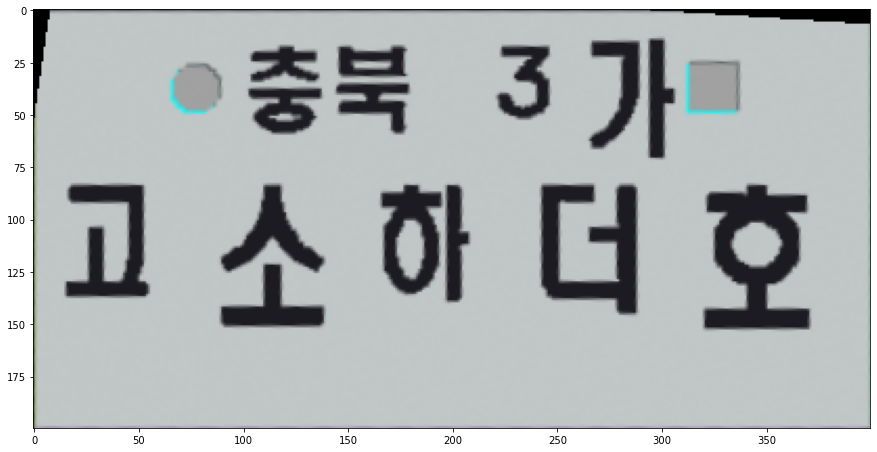

In [80]:
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

### tflite

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [158]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprmjnszqc/assets


INFO:tensorflow:Assets written to: /tmp/tmprmjnszqc/assets


In [159]:
input_sample = input_list_train[-1]
input_sample.shape

(180, 1100, 3)

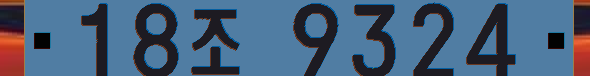

In [160]:
img = Image.fromarray(input_sample[52:-52,255:-255])
img

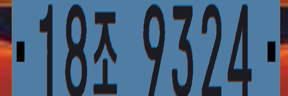

In [161]:
img_resized = img.resize((padded_image_shape[1],padded_image_shape[0]))
img_resized

In [162]:
input_sample = np.expand_dims(np.array(img_resized), 0)

In [163]:
num_classes

118

In [164]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details, output_details

([{'name': 'input_4',
   'index': 0,
   'shape': array([  1,  96, 288,   3], dtype=int32),
   'shape_signature': array([ -1,  96, 288,   3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'Identity',
   'index': 206,
   'shape': array([1, 6], dtype=int32),
   'shape_signature': array([-1,  6], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}},
  {'name': 'Identity_1',
   'index': 1011,
   'shape': array([  1,   9, 120], dtype=int32),
   'shape_signature': array([ -1,   9, 120], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([]

In [165]:

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(input_sample, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_results = interpreter.get_tensor(output_details[1]['index'])
cxy = tflite_results[0, :, :2]
cls_score = tflite_results[0, :, 2:]
cls_arg_max = np.argmax(cls_score, -1)
cxy, tflite_results.shape, cls_arg_max

(array([[-0.67,  0.05],
        [-0.4 , -0.02],
        [-0.24, -0.1 ],
        [ 0.01, -0.  ],
        [ 0.27, -0.03],
        [ 0.57, -0.02],
        [ 0.4 ,  0.12],
        [ 0.61,  0.19],
        [-0.55,  0.34]], dtype=float32),
 (1, 9, 120),
 array([ 1,  4, 62,  9,  6,  4,  6,  4,  0]))

In [ ]:
for var in model.trainable_variables:
    print(var.name, var.shape)